In [14]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from ROC import get_DIs
from ROC import get_DIs_psycho

from scipy.optimize import curve_fit
from lmfit import Model
from scipy.interpolate import interp1d

%matplotlib inline

In [15]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [16]:
def get_SI(PF, NF):
    return -(np.sqrt(np.sum((PF - NF)**2)) - np.sqrt(np.sum(PF**2)))/np.sqrt(np.sum(PF**2))

In [55]:
get_SI(DI_stim[4], NF)

-4.4234787606464074

In [17]:
filename = filelist[2]
f = h5py.File(filename+".hdf5", "r")

In [18]:
meta = f['meta']
stims = np.unique(meta[:,1])

#compute hits/misses
NF = []
for stim in stims:
    trials_mask = meta[:,1]==stim
    rate = np.sum(meta[trials_mask,2]==1)/np.sum(meta[trials_mask,2].shape[0]) #hits over misses
    NF.append(rate)

In [57]:
n = 97
n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
n_dendrites = np.sum(motion_mask)

DI_stim = np.zeros((n_dendrites, stims.shape[0]))

#get highest average DIs
for k, stim in enumerate(stims[1:]):
    DI_stim[:,k+1] = get_DIs(filename, stim)
    
avs = np.mean(DI_stim, axis=1)
avs_inds = np.argsort(avs)

inds_pos = avs_inds[::-1][:n]
inds_neg = avs_inds[:n]

SIs_pos = []
SIs_neg = []
for i in range(n):
    PF = DI_stim[inds_pos[i]]
    SI_pos = get_SI(PF, NF)
    
    PF = DI_stim[inds_neg[i]]
    SI_neg = get_SI(PF, NF)
    
    SIs_pos.append(SI_pos)
    SIs_neg.append(SI_neg)
    
p_ind = np.argmax(SIs_pos)
n_ind = np.argmin(SIs_neg)

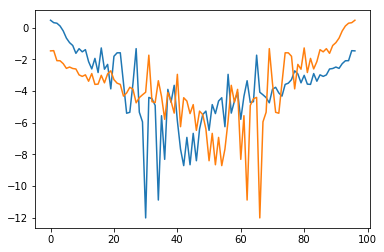

In [58]:
plt.plot(SIs_pos)
plt.plot(SIs_neg)

(array([  2.,   0.,   4.,   1.,   8.,  16.,  25.,  20.,  15.,   6.]),
 array([-12.01050838, -10.76359824,  -9.5166881 ,  -8.26977796,
         -7.02286782,  -5.77595768,  -4.52904754,  -3.28213739,
         -2.03522725,  -0.78831711,   0.45859303]),
 <a list of 10 Patch objects>)

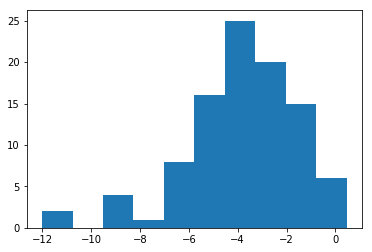

In [59]:
plt.hist(SIs_pos)

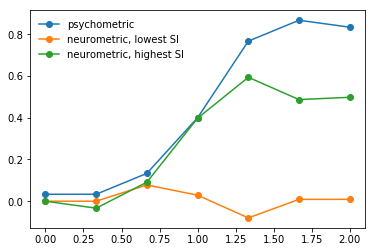

In [60]:
plt.errorbar(stims, NF, fmt='-o', label='psychometric')
plt.errorbar(stims, DI_stim[inds_neg[n_ind]], fmt='-o', label='neurometric, lowest SI')
plt.errorbar(stims, DI_stim[inds_pos[p_ind]], fmt='-o', label='neurometric, highest SI')
plt.legend(frameon=False)
#plt.errorbar(stims, neg[0])
#plt.ylim(0,1)

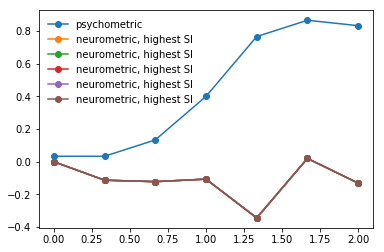

In [50]:
plt.errorbar(stims, NF, fmt='-o', label='psychometric')
#plt.errorbar(stims, DI_stim[1], fmt='-o', label='neurometric, lowest SI')
for i in range(0,5):
    plt.errorbar(stims, DI_stim[85], fmt='-o', label='neurometric, highest SI')
plt.legend(frameon=False)
#plt.errorbar(stims, neg[0])
#plt.ylim(0,1)

In [23]:
pos[0]

NameError: name 'pos' is not defined

In [24]:
def logistic(x, gamma, lamb, beta, alpha):
    return gamma + (1-gamma-lamb)/(1+np.exp(-beta*(x-alpha)))

def logistic2(x, beta, alpha):
    return (1)/(1+np.exp(-beta*(x-alpha)))

In [70]:
f = interp1d(stims, NF)
x = np.linspace(0,stims[-1], 100)
y = f(x)
popt, pcov = curve_fit(logistic, x, y, p0=[0,0.15,5, 1])
a, b, c, d = popt

0.02849933313620303

In [71]:
x = np.linspace(0,stims[-1], 100)
y = logistic(x, a,  b,  c,  d)

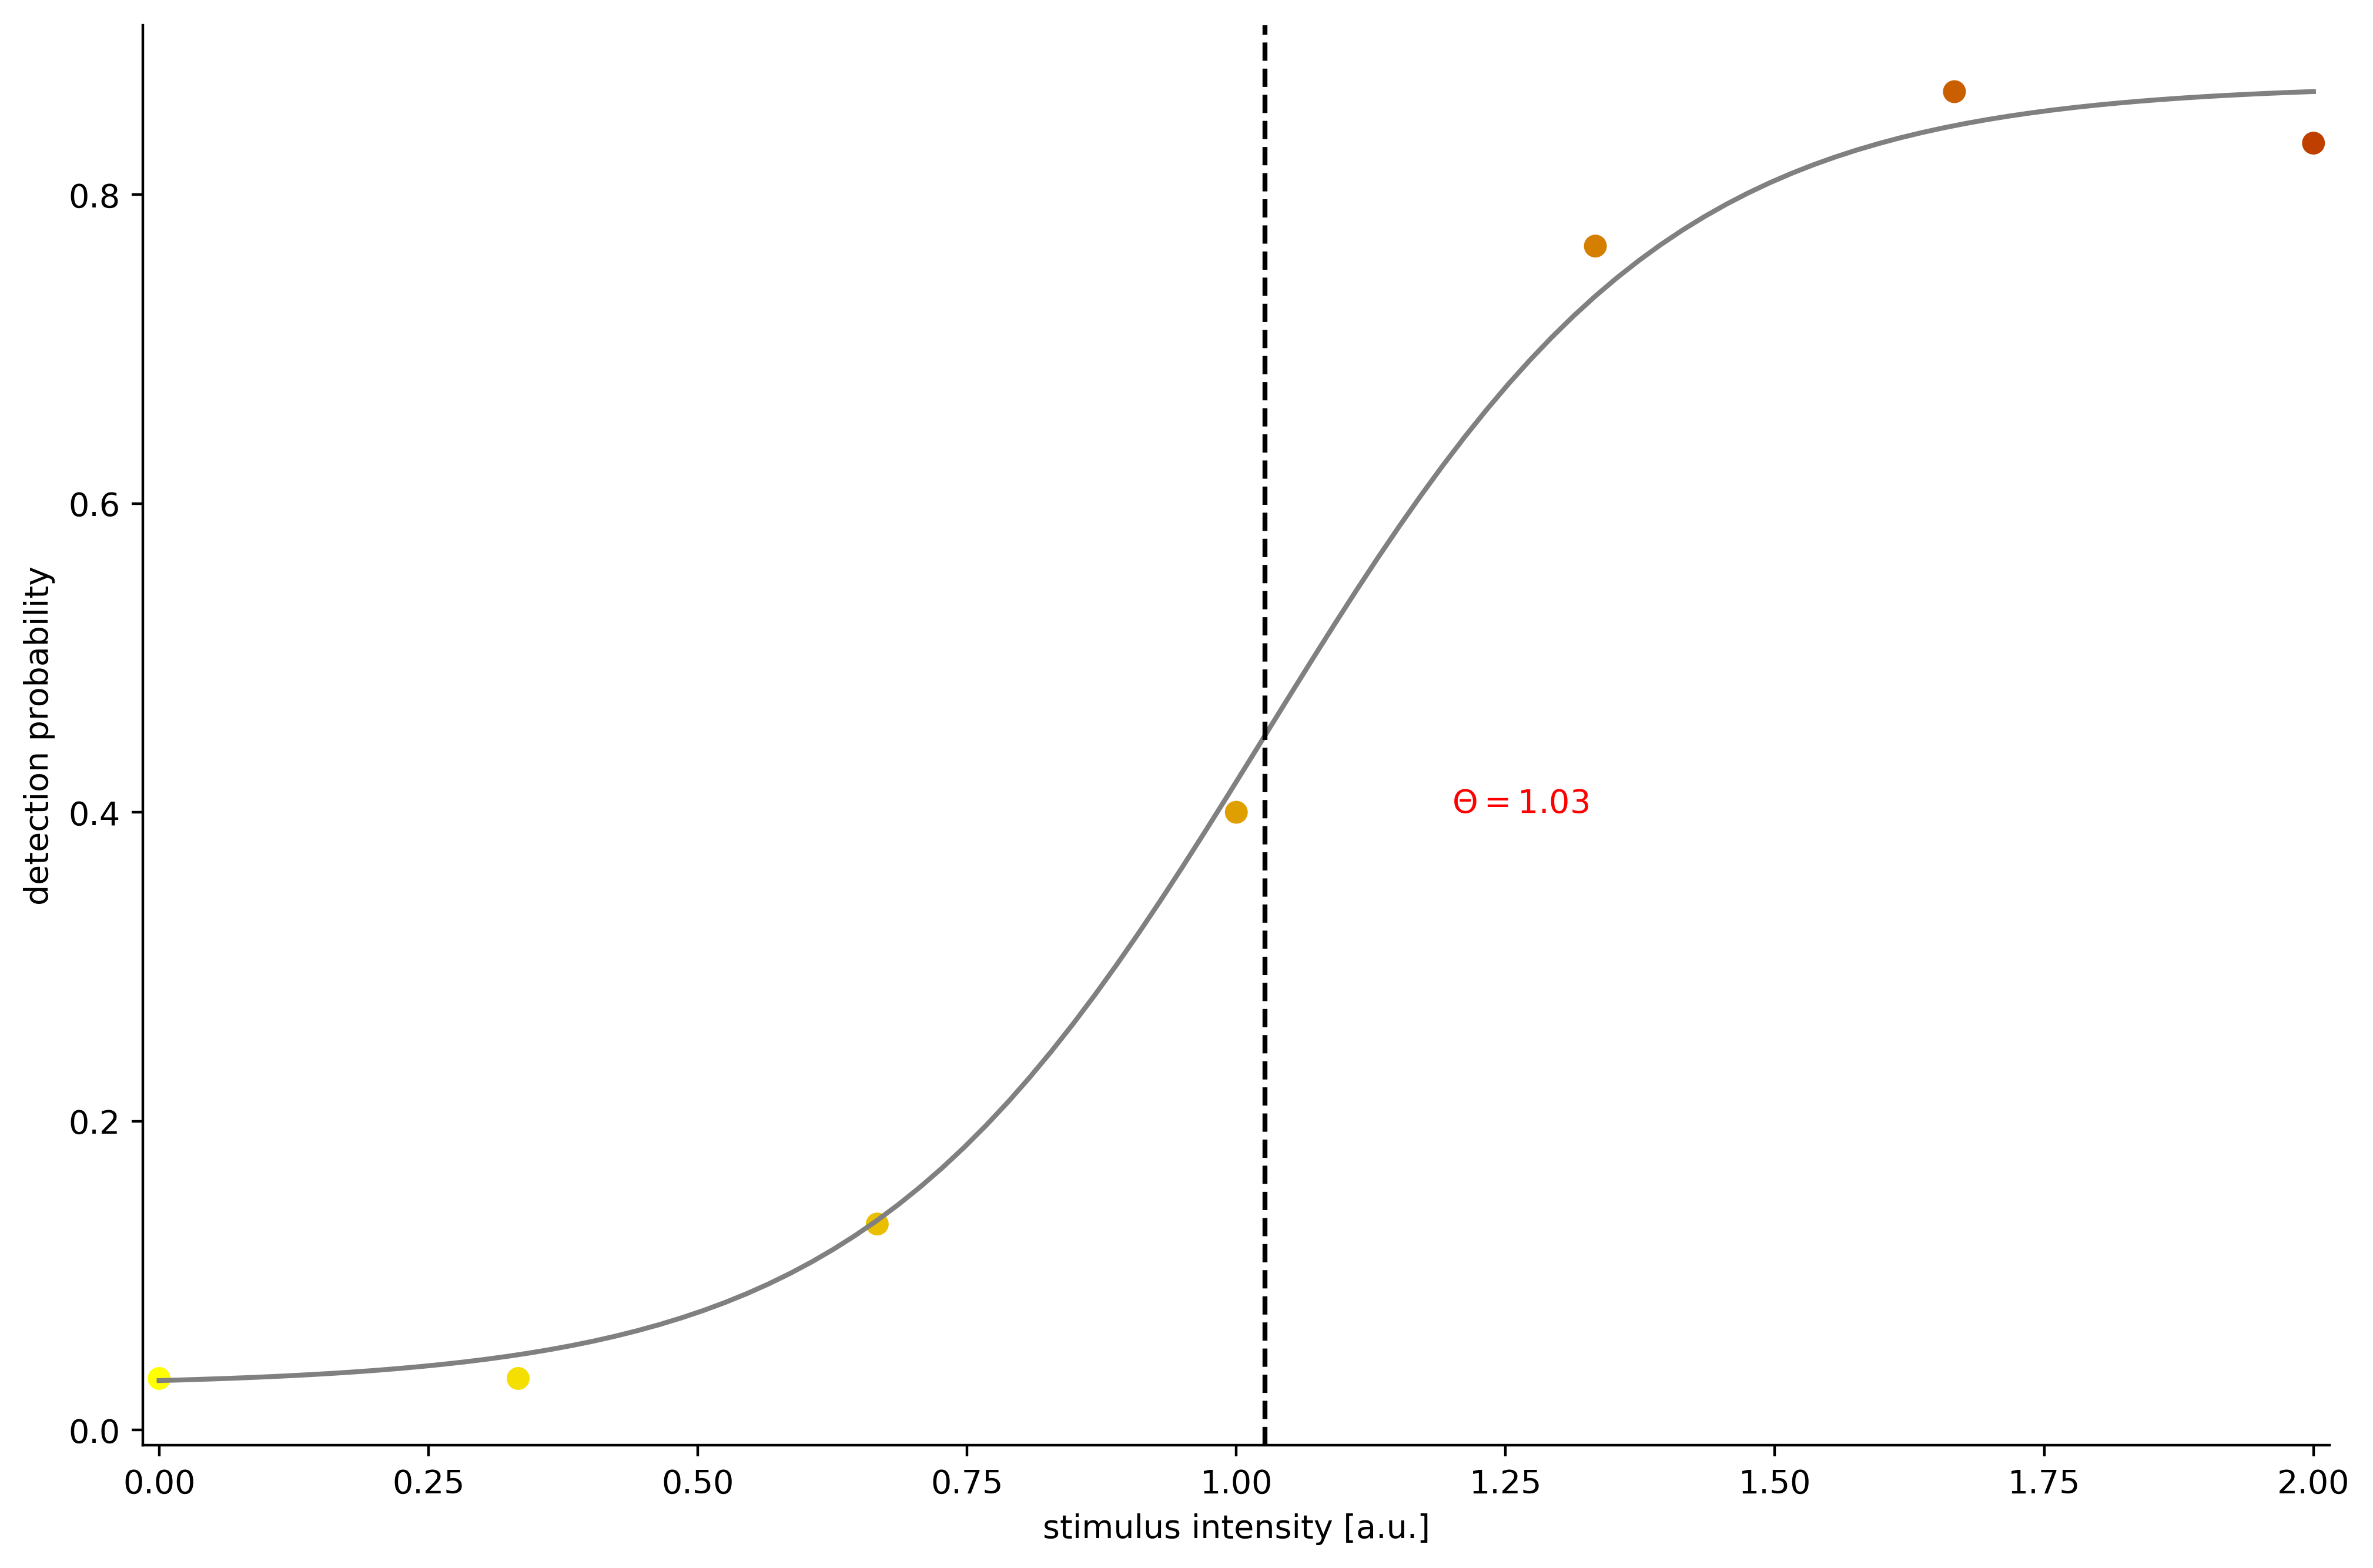

In [104]:
colors = ['#BF3F00', '#CA5F00', '#D47F00', '#DF9F00', '#EABF00', '#F4DF00', '#FFFF00'][::-1]

h, ax = plt.subplots(1,1, figsize=(12,8), dpi=400)

ax.scatter(stims, NF, label='psychometric', color=colors)
ax.plot(x, y, color='gray')
ax.axvline(d, linestyle='--', color='black')
ax.text(1.2,0.4,s='$\Theta={0: .2f}$'.format(d), color='red')

ax.set_xlim(-0.015,stims[-1]+0.015)

ax.set_xlabel('stimulus intensity [a.u.]')
ax.set_ylabel('detection probability')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

h.savefig('psychometric.png')

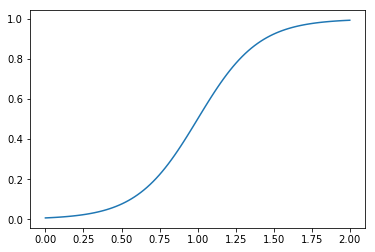

In [172]:
x = np.linspace(0,2, 100)
y = logistic(x, 0, 0, 5, 1)
popt, pcov = curve_fit(logistic, stims, NF, p0=[0,0.15,5, 1], bounds=([0, 0.15, 2, -1], [0.01, 0.151, 8, 5]))

plt.plot(x,y)

In [173]:
popt

array([  1.00000000e-10,   1.50000000e-01,   5.00000000e+00,
         1.00000000e+00])